In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import re
import plotly.express as px

In [2]:
# Read file dropping misaligned rows (4 total)
file_path = r'C:/Users/lucyc/Documents/books.csv'
df_GoodReads = pd.read_csv(file_path, on_bad_lines='skip', index_col='bookID')
df_GoodReads.head()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [3]:
df_GoodReads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11123 entries, 1 to 45641
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               11123 non-null  object 
 1   authors             11123 non-null  object 
 2   average_rating      11123 non-null  float64
 3   isbn                11123 non-null  object 
 4   isbn13              11123 non-null  int64  
 5   language_code       11123 non-null  object 
 6     num_pages         11123 non-null  int64  
 7   ratings_count       11123 non-null  int64  
 8   text_reviews_count  11123 non-null  int64  
 9   publication_date    11123 non-null  object 
 10  publisher           11123 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 1.0+ MB


In [4]:
# We have extracted the metadata from the isbn number using isbnlib standard library

df_isbn_metadata = pd.read_csv('C:/Users/lucyc/Documents/Projects/ML Python/isbn_metadata.csv', index_col='bookID')
df_isbn_metadata.head()

,Title,Authors,Publisher,Year,Language,ISBN-13
bookID,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN
2,Harry Potter,['J. K. Rowling'],NaN,2008,en,9.780439e+12
4,Harry Potter And The Chamber Of Secrets,"['J. K. Rowling', 'Mary GrandPre']",Arthur a Levine,2003,en,9.780440e+12
5,Harry Potter And The Prisoner Of Azkaban,['J. K. Rowling'],Scholastic Paperbacks,2004,en,9.780440e+12
8,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_isbn_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11123 entries, 1 to 45641
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      10513 non-null  object 
 1   Authors    10513 non-null  object 
 2   Publisher  9064 non-null   object 
 3   Year       10502 non-null  object 
 4   Language   10513 non-null  object 
 5   ISBN-13    10513 non-null  float64
dtypes: float64(1), object(5)
memory usage: 608.3+ KB


In [6]:
# The isbn metadata is missing 600 rows and 2000 values for pubisher
# We found that all the data we can get from the isbn number is already in our Goodreads DF so we can drop these two columns
df_GoodReads = df_GoodReads.drop('isbn', axis=1)
df_GoodReads = df_GoodReads.drop('isbn13', axis=1)

In [7]:
df_GoodReads.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000
mean,3.934075,336.405556,1.794285e+04,542.048099
std,0.350485,241.152626,1.124992e+05,2576.619589
min,0.000000,0.000000,0.000000e+00,0.000000
25%,3.770000,192.000000,1.040000e+02,9.000000
50%,3.960000,299.000000,7.450000e+02,47.000000
75%,4.140000,416.000000,5.000500e+03,238.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000


In [8]:
# We can see that 50% of average ratings lie between 3.78 and 4.14
# We will now observe lower ratings to identify trends
df_GoodReads[df_GoodReads['average_rating'] < 3]

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,
159,Dinner with Anna Karenina,Gloria Goldreich,2.99,eng,360,411,65,1/28/2006,Mira Books
799,Out to Eat London 2002 (Lonely Planet Out to Eat),Lonely Planet/Mark Honan,0.00,eng,295,0,0,9/1/2001,Lonely Planet
1302,Juiced Official Strategy Guide,Doug Walsh,0.00,eng,112,0,0,6/1/2005,BradyGames
1584,Cliffs Notes on Aristophanes' Lysistrata The ...,W. John Campbell,2.80,eng,80,5,0,12/29/1983,Cliffs Notes
1658,American Government: Continuity and Change Al...,Karen O'Connor/Larry J. Sabato,2.83,eng,664,0,0,3/11/2005,Longman Publishing Group
...,...,...,...,...,...,...,...,...,...
42808,P.S. I Love You (Sealed with a Kiss #4),Valerie Parv,2.83,eng,192,23,1,4/24/1995,Harlequin Romance
42831,The Parrot-Head Companion: An Insider's Guide ...,Thomas Ryan,2.83,eng,176,6,0,1/1/1998,Citadel Press
44705,The Leadership Challenge: Skills for Taking Ch...,Warren G. Bennis,0.00,eng,60,0,0,12/1/1985,AMR/Advanced Management Reports


In [9]:
# We see here we have some 0 ratings counts which will not help us in predicting rating
# We can therefore drop these rows
df_GoodReads = df_GoodReads[df_GoodReads['ratings_count'] != 0]

In [10]:
# We will start by cleaning up the title column of the goodreads dataframe by extracting the main title only
df_GoodReads['title'] = df_GoodReads['title'].str.split("(").str[0]

In [11]:
# Removing duplicates
df_GoodReads = df_GoodReads.loc[df_GoodReads.groupby(['title', 'authors', 'average_rating'])['ratings_count'].idxmax()]

In [12]:
# And fixing num_pages header to get rid of leading spaces
df_GoodReads.rename(columns={'  num_pages': 'num_pages'}, inplace=True)

In [13]:
# TITLE - COMMON PHRASES
# We can see from the title column we have numerous titles with common strings
# We will create a new column to group together these common titles

# Defining connective words and eliminating them from the title
connective_words = {'and', 'the', 'of', 'in', 'a', 'to'}

def preprocess_title(title):
    words = title.split()
    return ' '.join([word for word in words if word.lower() not in connective_words])

df_GoodReads['processed_title'] = df_GoodReads['title'].apply(preprocess_title)

# Identifying Bigrams and Trigrams to group together common title phrases
vectorizer = CountVectorizer(ngram_range=(2,3))
X = vectorizer.fit_transform(df_GoodReads['processed_title'])

phrases = vectorizer.get_feature_names_out()
phrase_counts = X.sum(axis=0).tolist()[0]
phrase_dict = {phrase: count for phrase, count in zip(phrases, phrase_counts)}

# Searching for common phrases and returning the title if no common phrase found
def find_common_phrase(title):
    processed_title = preprocess_title(title)
    title_phrases = vectorizer.transform([processed_title])
    title_phrase_counts = title_phrases.toarray().flatten()

    max_count = 0
    max_phrase = None
    for phrase, idx in vectorizer.vocabulary_.items():
        if title_phrase_counts[idx] > 0:
            if phrase_dict[phrase] > max_count:
                max_count = phrase_dict[phrase]
                max_phrase = phrase
    if max_phrase:
        return ' '.join([word.capitalize() for word in max_phrase.split()])
    else:
        return title

df_GoodReads['titles_grouped'] = df_GoodReads['title'].apply(find_common_phrase)

title_counts = df_GoodReads['titles_grouped'].value_counts()
for title in title_counts[title_counts > 1].index:
    df_GoodReads.loc[df_GoodReads['titles_grouped'] == title, 'titles_grouped']= title

df_GoodReads = df_GoodReads.drop(columns = ['processed_title'])
df_GoodReads.head()


,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,titles_grouped
bookID,,,,,,,,,,
6549,said the shotgun to the head.,Saul Williams,4.22,en-US,192,2762,214,9/1/2003,MTV Books,Said Shotgun
14490,$30 Film School: How to Write Direct Produce...,Michael W. Dean,3.49,eng,528,30,4,5/13/2003,Cengage Learning,How Write
5415,'Salem's Lot,Stephen King,4.02,eng,405,1039,130,10/17/1975,Doubleday,Salem Lot
5413,'Salem's Lot,Stephen King/Jerry N. Uelsmann,4.25,eng,594,84123,571,11/1/2005,Doubleday,Salem Lot
5414,'Salem's Lot,Stephen King/Ron McLarty,4.02,eng,17,227,54,1/19/2004,Simon & Schuster Audio,Salem Lot


In [14]:
# Now we want to see if title group has an impact on average rating
df_GoodReads.titles_grouped.value_counts()

titles_grouped
Other Stories          46
Star Wars              39
Short Stories          34
Lord Rings             28
Harry Potter           26
                       ..
Jenny                   1
Jennifer Government     1
Jennifer Hecate         1
Jeeves Offing           1
魔戒首部曲 魔戒現身              1
Name: count, Length: 7598, dtype: int64

<Axes: xlabel='title_frequency', ylabel='average_rating'>

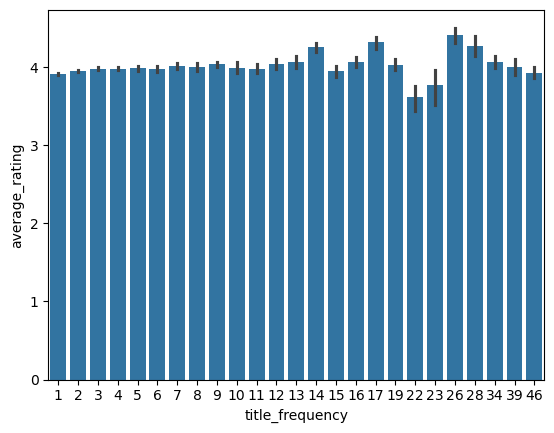

In [15]:
frequency_encoding = df_GoodReads['titles_grouped'].value_counts().to_dict()
df_GoodReads['title_frequency'] = df_GoodReads['titles_grouped'].map(frequency_encoding)
sns.barplot(x='title_frequency', y='average_rating', data= df_GoodReads)

In [16]:
# Group together unique titles
threshold_unique= 1
title_groups = df_GoodReads['titles_grouped'].value_counts()
unique_titles = title_groups[title_groups <= threshold_unique].index
df_GoodReads['titles_grouped'] = df_GoodReads['titles_grouped'].apply(lambda x: 'Unique' if x in unique_titles else x)

<Axes: xlabel='titles_grouped', ylabel='average_rating'>

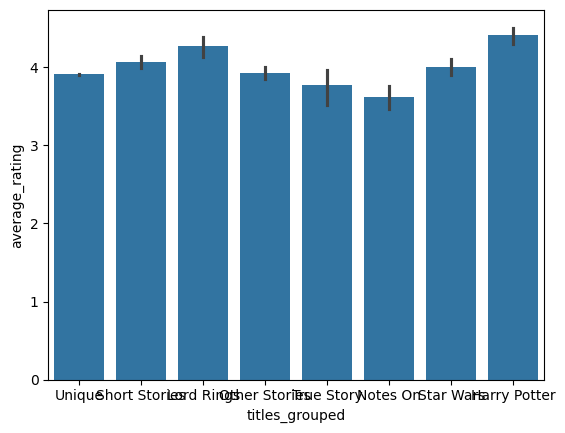

In [17]:
# We will zoom in on the groups which contain over 20 books to observe
counts = df_GoodReads['titles_grouped'].value_counts()
to_keep = counts[counts > 20].index
df_title_count_filter = df_GoodReads[df_GoodReads['titles_grouped'].isin(to_keep)]
sns.barplot(x='titles_grouped', y='average_rating', data= df_title_count_filter)

In [18]:
df_GoodReads.authors.value_counts()

authors
P.G. Wodehouse                           39
Rumiko Takahashi                         38
Orson Scott Card                         33
Agatha Christie                          31
Stephen King                             30
                                         ..
Philip Nel                                1
Sean Smith                                1
Walter Scott/Graham Tulloch               1
Marianna Mayer/Walter Scott/John Rush     1
Marguerite Henry/Wesley Dennis            1
Name: count, Length: 6583, dtype: int64

In [19]:
df_GoodReads.head()

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,titles_grouped,title_frequency
bookID,,,,,,,,,,,
6549,said the shotgun to the head.,Saul Williams,4.22,en-US,192,2762,214,9/1/2003,MTV Books,Unique,1
14490,$30 Film School: How to Write Direct Produce...,Michael W. Dean,3.49,eng,528,30,4,5/13/2003,Cengage Learning,How Write,4
5415,'Salem's Lot,Stephen King,4.02,eng,405,1039,130,10/17/1975,Doubleday,Salem Lot,5
5413,'Salem's Lot,Stephen King/Jerry N. Uelsmann,4.25,eng,594,84123,571,11/1/2005,Doubleday,Salem Lot,5
5414,'Salem's Lot,Stephen King/Ron McLarty,4.02,eng,17,227,54,1/19/2004,Simon & Schuster Audio,Salem Lot,5


In [20]:
# Finding the most frequently occuring author in each row
split_strings = df_GoodReads['authors'].str.split('/')
authors_sep = [item for sublist in split_strings for item in sublist]
author_counts = Counter(authors_sep)

def find_mf_author(authors_list):
    most_frequent = max(authors_list, key=lambda x: author_counts[x])
    return most_frequent

df_GoodReads['main_author'] = split_strings.apply(find_mf_author)
df_GoodReads.head()

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,titles_grouped,title_frequency,main_author
bookID,,,,,,,,,,,,
6549,said the shotgun to the head.,Saul Williams,4.22,en-US,192,2762,214,9/1/2003,MTV Books,Unique,1,Saul Williams
14490,$30 Film School: How to Write Direct Produce...,Michael W. Dean,3.49,eng,528,30,4,5/13/2003,Cengage Learning,How Write,4,Michael W. Dean
5415,'Salem's Lot,Stephen King,4.02,eng,405,1039,130,10/17/1975,Doubleday,Salem Lot,5,Stephen King
5413,'Salem's Lot,Stephen King/Jerry N. Uelsmann,4.25,eng,594,84123,571,11/1/2005,Doubleday,Salem Lot,5,Stephen King
5414,'Salem's Lot,Stephen King/Ron McLarty,4.02,eng,17,227,54,1/19/2004,Simon & Schuster Audio,Salem Lot,5,Stephen King


In [21]:
df_GoodReads.main_author.value_counts()

main_author
William Shakespeare    91
Stephen King           83
J.R.R. Tolkien         50
Sandra Brown           46
P.G. Wodehouse         46
                       ..
Shirin Ebadi            1
Ashley Shannon          1
Darina Allen            1
Christopher   Clark     1
Lolita Files            1
Name: count, Length: 3875, dtype: int64

In [22]:
df_GoodReads.authors.value_counts()

authors
P.G. Wodehouse                           39
Rumiko Takahashi                         38
Orson Scott Card                         33
Agatha Christie                          31
Stephen King                             30
                                         ..
Philip Nel                                1
Sean Smith                                1
Walter Scott/Graham Tulloch               1
Marianna Mayer/Walter Scott/John Rush     1
Marguerite Henry/Wesley Dennis            1
Name: count, Length: 6583, dtype: int64

In [23]:
# AUTHORS - FREQUENCY
# We have numerous repeat authors in our dataframe and would like to see if the frequency of an authors appearance in the dataframe affects rating
# For this we will use frequency encoding
df_GoodReads['authors'] = df_GoodReads['authors'].str.split("/").str[0]
frequency_encoding = df_GoodReads['authors'].value_counts().to_dict()
df_GoodReads['author_frequency'] = df_GoodReads['authors'].map(frequency_encoding)

In [24]:

frequency_encoding = df_GoodReads['main_author'].value_counts().to_dict()
df_GoodReads['main_author_frequency'] = df_GoodReads['main_author'].map(frequency_encoding)

<Axes: xlabel='author_frequency', ylabel='average_rating'>

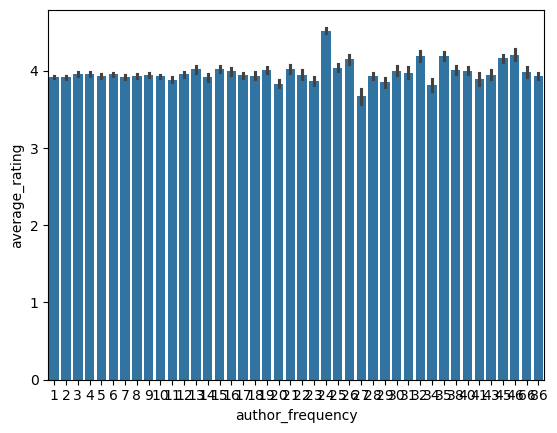

In [25]:
sns.barplot(x='author_frequency', y='average_rating', data=df_GoodReads)

In [26]:
df_GoodReads.language_code.value_counts()

language_code
eng      8608
en-US    1358
spa       200
en-GB     197
fre       136
ger        93
jpn        45
mul        19
zho        14
por        10
grc         9
en-CA       7
ita         5
enm         3
lat         3
swe         2
rus         2
ara         1
nl          1
msa         1
ale         1
glg         1
nor         1
tur         1
wel         1
gla         1
Name: count, dtype: int64

In [27]:
# LANGUAGE CODE
# We will group all the english language codes together as one
def modify_language(lang):
    if lang.startswith('en'):
        return 'eng'
    return lang

df_GoodReads['language_code'] = df_GoodReads['language_code'].apply(modify_language)

In [371]:
df_GoodReads.language_code.value_counts()

language_code
eng    10173
spa      200
fre      136
ger       93
jpn       45
mul       19
zho       14
por       10
grc        9
ita        5
lat        3
rus        2
swe        2
wel        1
gla        1
nor        1
msa        1
glg        1
ale        1
nl         1
ara        1
tur        1
Name: count, dtype: int64

<Axes: xlabel='language_code', ylabel='average_rating'>

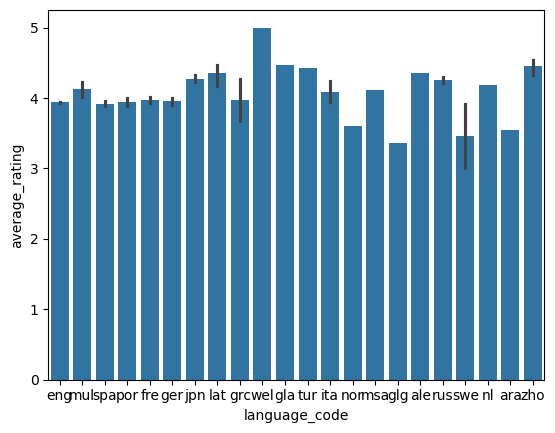

In [372]:

sns.barplot(x='language_code', y='average_rating', data=df_GoodReads)

In [28]:
# We can see from this barplot that the average ratings for the highly represented languages are very similar
# And the permutations occur only for language codes with 1 or 2 representants on goodreads
# The underrepresented countries will be grouped together to observe
threshold= 10
language_counts = df_GoodReads['language_code'].value_counts()
underrepresented_languages = language_counts[language_counts < threshold].index
df_GoodReads['language_code'] = df_GoodReads['language_code'].apply(lambda x: 'Other' if x in underrepresented_languages else x)

<Axes: xlabel='language_code', ylabel='average_rating'>

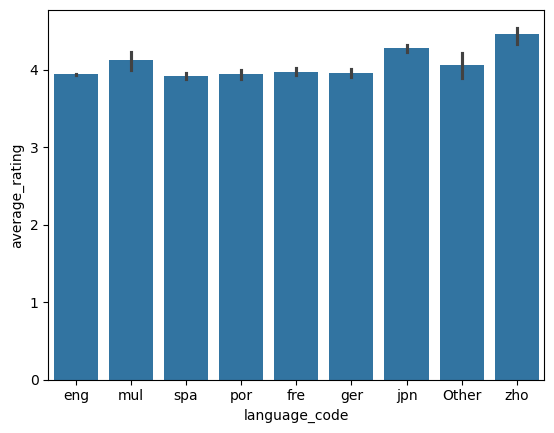

In [374]:
sns.barplot(x='language_code', y='average_rating', data=df_GoodReads)

<Axes: xlabel='average_rating', ylabel='language_code'>

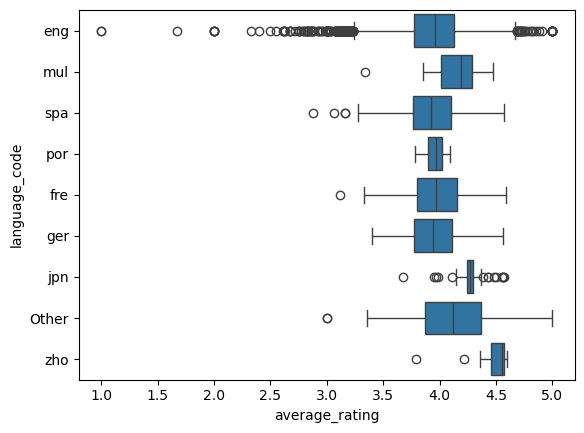

In [29]:
sns.boxplot(data=df_GoodReads, x='average_rating', y='language_code')

In [375]:
# We can see that the average rating and spread of data for eng, fre, spa and ger are all very similar
# As these countries make up 98% of our data, we will drop this column
df_GoodReads = df_GoodReads.drop('language_code', axis=1)

In [376]:
df_GoodReads.head()

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,publisher,titles_grouped,title_frequency,main_author,author_frequency,main_author_frequency
bookID,,,,,,,,,,,,,
6549,said the shotgun to the head.,Saul Williams,4.22,192,2762,214,9/1/2003,MTV Books,Unique,1,Saul Williams,1,1
14490,$30 Film School: How to Write Direct Produce...,Michael W. Dean,3.49,528,30,4,5/13/2003,Cengage Learning,How Write,4,Michael W. Dean,1,1
5415,'Salem's Lot,Stephen King,4.02,405,1039,130,10/17/1975,Doubleday,Salem Lot,5,Stephen King,66,83
5413,'Salem's Lot,Stephen King,4.25,594,84123,571,11/1/2005,Doubleday,Salem Lot,5,Stephen King,66,83
5414,'Salem's Lot,Stephen King,4.02,17,227,54,1/19/2004,Simon & Schuster Audio,Salem Lot,5,Stephen King,66,83


In [377]:
# PUBLISHER
df_GoodReads.publisher.value_counts().head(30)

publisher
Vintage                         310
Penguin Books                   252
Penguin Classics                180
Mariner Books                   147
Ballantine Books                141
HarperCollins                   109
Bantam                          108
Harper Perennial                106
Pocket Books                    104
VIZ Media LLC                    88
Dover Publications               85
Berkley                          85
Modern Library                   81
Del Rey                          80
Oxford University Press  USA     74
Tor Books                        73
Grand Central Publishing         73
Oxford University Press          72
Scribner                         71
W. W. Norton  Company            67
Cambridge University Press       65
Simon  Schuster                  65
Anchor                           60
Signet                           59
William Morrow Paperbacks        57
Avon                             56
Scholastic Paperbacks            55
Penguin           

In [378]:
# We have some values where we appear to have a main publishing house (Penguin) and a complementing branch (Books, Classics)
# We want to know if the main house or the branch has a bigger impact than the other on rating

In [30]:
pub_words = ' '.join(df_GoodReads['publisher'])
pub_words_clean = re.sub(r'[^\w\s]', '', pub_words).lower()
words = pub_words_clean.split()
word_counts = Counter(words)
common_pubs = word_counts.most_common(50)
print(common_pubs)

[('books', 2217), ('press', 1284), ('penguin', 577), ('university', 543), ('publishing', 484), ('vintage', 394), ('classics', 331), ('company', 324), ('house', 306), ('of', 275), ('w', 226), ('library', 223), ('harper', 217), ('paperbacks', 207), ('random', 198), ('publishers', 194), ('bantam', 190), ('simon', 182), ('harpercollins', 181), ('berkley', 169), ('schuster', 161), ('for', 152), ('oxford', 150), ('media', 150), ('publications', 148), ('mariner', 148), ('ballantine', 148), ('readers', 146), ('young', 144), ('pocket', 142), ('perennial', 140), ('norton', 140), ('st', 139), ('martins', 139), ('and', 131), ('usa', 127), ('scholastic', 126), ('inc', 123), ('viz', 122), ('audio', 120), ('modern', 118), ('del', 118), ('rey', 117), ('anchor', 104), ('tor', 104), ('llc', 103), ('william', 100), ('morrow', 98), ('group', 96), ('signet', 93)]


<Axes: xlabel='publisher', ylabel='average_rating'>

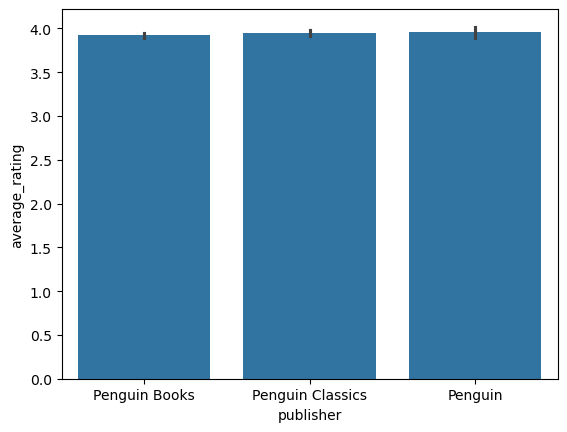

In [380]:
# We will examine some of the most highly represented publishing houses
penguin_books = ['Penguin', 'Penguin Books', 'Penguin Classics']
penguin_df = df_GoodReads[df_GoodReads['publisher'].isin(penguin_books)]
sns.barplot(x='publisher', y='average_rating', data= penguin_df)

<Axes: xlabel='publisher', ylabel='average_rating'>

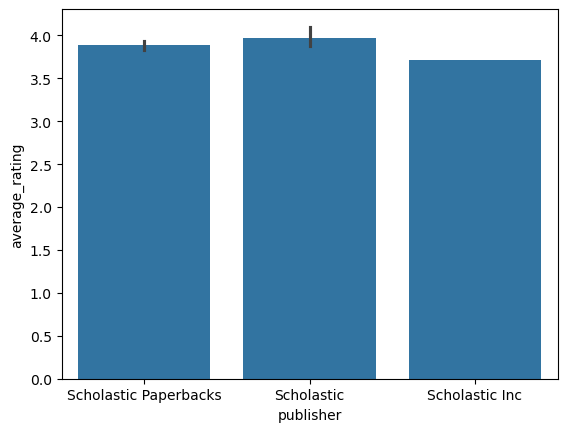

In [381]:
scholastic_books = ['Scholastic', 'Scholastic Inc', 'Scholastic Paperbacks']
scholastic_df = df_GoodReads[df_GoodReads['publisher'].isin(scholastic_books)]
sns.barplot(x='publisher', y='average_rating', data= scholastic_df)

<Axes: xlabel='publisher', ylabel='average_rating'>

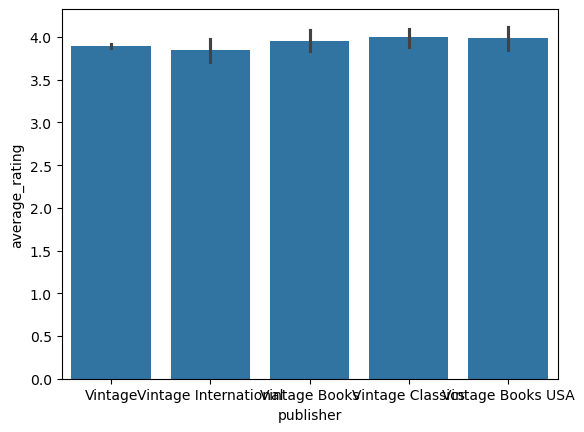

In [382]:
vintage_books = ['Vintage', 'Vintage Books', 'Vintage Classics', 'Vintage International', 'Vintage Books USA']
vintage_df = df_GoodReads[df_GoodReads['publisher'].isin(vintage_books)]
sns.barplot(x='publisher', y='average_rating', data= vintage_df)

<Axes: xlabel='publisher', ylabel='average_rating'>

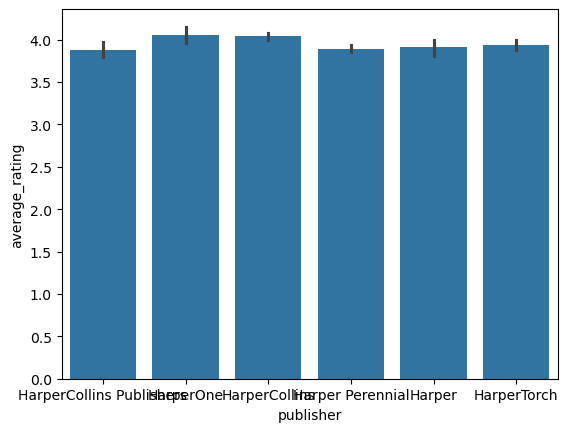

In [383]:
harper_books = ['Harper', 'HarperTorch', 'HarperOne', 'HarperCollins', 'HarperCollins Publishers', 'Harper Perennial']
harper_df = df_GoodReads[df_GoodReads['publisher'].isin(harper_books)]
sns.barplot(x='publisher', y='average_rating', data= harper_df)

<Axes: xlabel='publisher', ylabel='average_rating'>

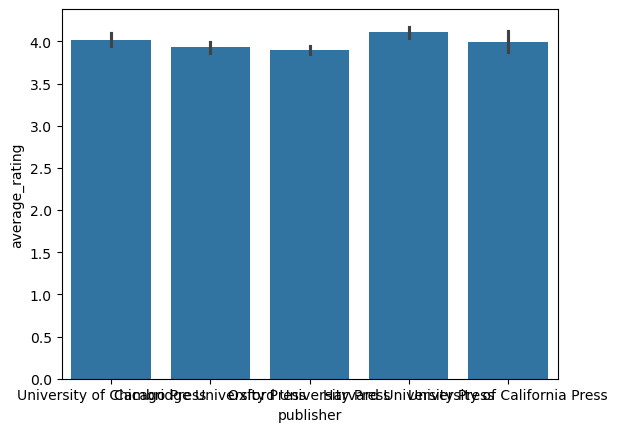

In [384]:
uni_books = ['University of Chicago Press', 'University of California Press', 'Harvard University Press', 'Oxford University Press', 'Cambridge University Press']
uni_df = df_GoodReads[df_GoodReads['publisher'].isin(uni_books)]
sns.barplot(x='publisher', y='average_rating', data= uni_df)

<Axes: xlabel='publisher', ylabel='average_rating'>

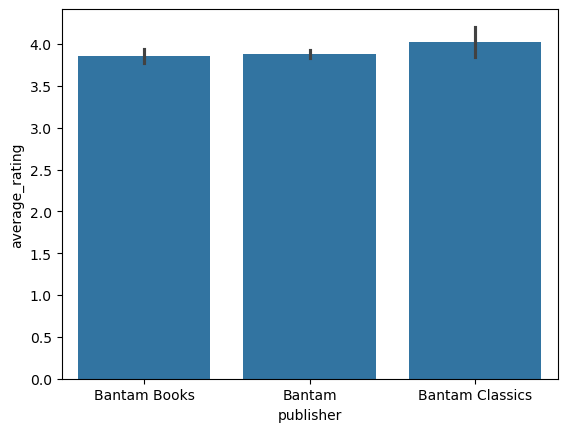

In [385]:
bantam_books = ['Bantam', 'Bantam Books', 'Bantam Classics']
bantam_df = df_GoodReads[df_GoodReads['publisher'].isin(bantam_books)]
sns.barplot(x='publisher', y='average_rating', data= bantam_df)

<Axes: xlabel='publisher', ylabel='average_rating'>

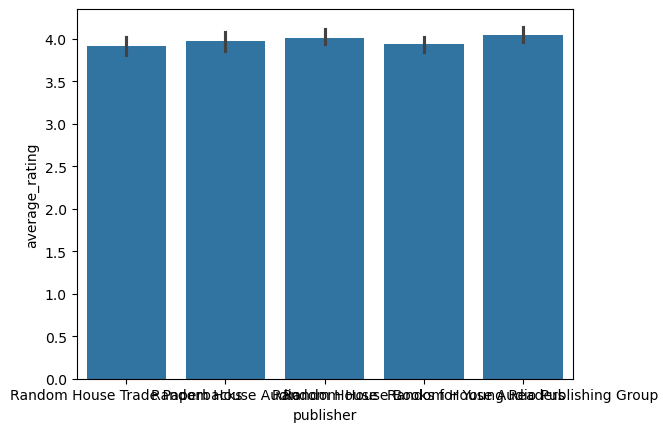

In [386]:
random_books = ['Random House', 'Random House Audio', 'Random House Audio Publishing Group', 'Random House Books for Young Readers', 'Random House Trade Paperbacks']
random_df = df_GoodReads[df_GoodReads['publisher'].isin(random_books)]
sns.barplot(x='publisher', y='average_rating', data= random_df)

In [387]:
# All main publishing houses appear to have an average rating of between 3.8 and 4

In [388]:
# We have seen the isbn metadata contains NA columns where we were unable to match the isbn - we will first observe this
df_isbn_metadata['Publisher'].isna().sum()

2059

In [31]:
# We will use the isbn metadata to find official publishing house linked with each isbn
# If no publisher information is found in the isbn metadata we will keep the publisher from GoodReads

df_GoodReads['publisher'] = df_isbn_metadata['Publisher'].where(df_isbn_metadata['Publisher'].notna(), df_GoodReads['publisher'])
df_GoodReads.head()

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,titles_grouped,title_frequency,main_author,author_frequency,main_author_frequency
bookID,,,,,,,,,,,,,,
6549,said the shotgun to the head.,Saul Williams,4.22,eng,192,2762,214,9/1/2003,MTV Books,Unique,1,Saul Williams,1,1
14490,$30 Film School: How to Write Direct Produce...,Michael W. Dean,3.49,eng,528,30,4,5/13/2003,Course Technology,How Write,4,Michael W. Dean,1,1
5415,'Salem's Lot,Stephen King,4.02,eng,405,1039,130,10/17/1975,Doubleday,Salem Lot,5,Stephen King,66,83
5413,'Salem's Lot,Stephen King,4.25,eng,594,84123,571,11/1/2005,Doubleday Books,Salem Lot,5,Stephen King,66,83
5414,'Salem's Lot,Stephen King,4.02,eng,17,227,54,1/19/2004,Simon & Schuster Audio,Salem Lot,5,Stephen King,66,83


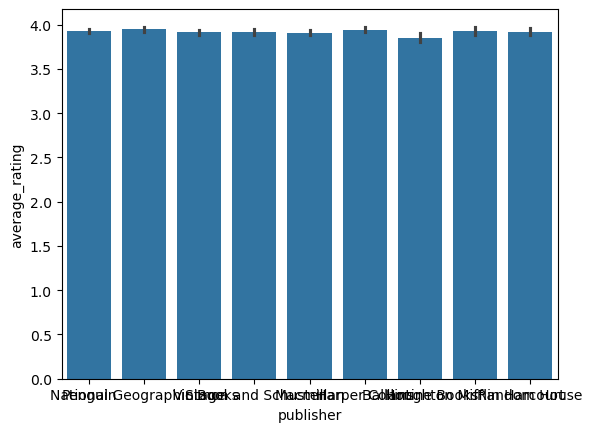

In [32]:
# Observing average rating of most common publishers

counts_pub = df_GoodReads['publisher'].value_counts()
to_keep_pub = counts_pub[counts_pub > 120].index
df_pub_count_filter = df_GoodReads[df_GoodReads['publisher'].isin(to_keep_pub)]
sns.barplot(x='publisher', y='average_rating', data= df_pub_count_filter)

frequency_encoding = df_GoodReads['publisher'].value_counts().to_dict()
df_GoodReads['publisher_frequency'] = df_GoodReads['publisher'].map(frequency_encoding)

<Axes: xlabel='average_rating', ylabel='publisher'>

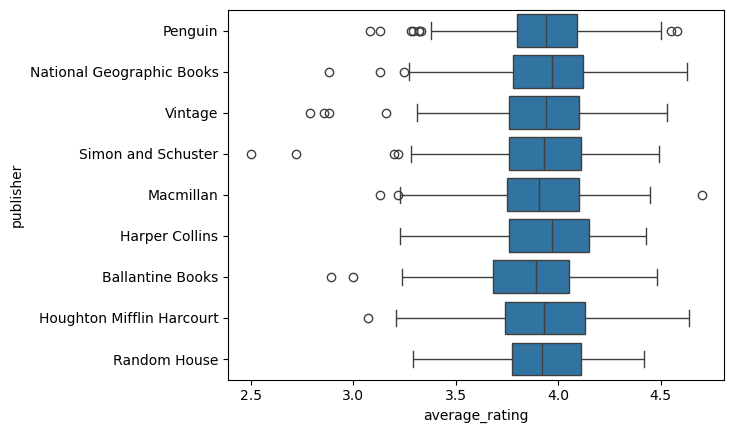

In [34]:
# Observing how the size of a publishing house affects rating

sns.boxplot(y='publisher', x='average_rating', data= df_pub_count_filter)

In [392]:
# Publication Date
df_GoodReads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10720 entries, 6549 to 15294
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  10720 non-null  object 
 1   authors                10720 non-null  object 
 2   average_rating         10720 non-null  float64
 3   num_pages              10720 non-null  int64  
 4   ratings_count          10720 non-null  int64  
 5   text_reviews_count     10720 non-null  int64  
 6   publication_date       10720 non-null  object 
 7   publisher              10720 non-null  object 
 8   titles_grouped         10720 non-null  object 
 9   title_frequency        10720 non-null  int64  
 10  main_author            10720 non-null  object 
 11  author_frequency       10720 non-null  int64  
 12  main_author_frequency  10720 non-null  int64  
 13  publisher_frequency    10720 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 1.5+ MB

In [35]:
# Extracting publication year and month into seperate columns to study individual importance
df_GoodReads['publication_year'] = df_GoodReads['publication_date'].str.split("/").str[2].astype(int)
df_GoodReads['publication_month'] = df_GoodReads['publication_date'].str.split("/").str[0].astype(int)
# Dropping full publication date as we have extracted the information needed
df_GoodReads = df_GoodReads.drop('publication_date', axis=1)

In [394]:
df_GoodReads.head()

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publisher,titles_grouped,title_frequency,main_author,author_frequency,main_author_frequency,publisher_frequency,publication_year,publication_month
bookID,,,,,,,,,,,,,,,
6549,said the shotgun to the head.,Saul Williams,4.22,192,2762,214,MTV Books,Unique,1,Saul Williams,1,1,2,2003,9
14490,$30 Film School: How to Write Direct Produce...,Michael W. Dean,3.49,528,30,4,Course Technology,How Write,4,Michael W. Dean,1,1,3,2003,5
5415,'Salem's Lot,Stephen King,4.02,405,1039,130,Doubleday,Salem Lot,5,Stephen King,66,83,6,1975,10
5413,'Salem's Lot,Stephen King,4.25,594,84123,571,Doubleday Books,Salem Lot,5,Stephen King,66,83,13,2005,11
5414,'Salem's Lot,Stephen King,4.02,17,227,54,Simon & Schuster Audio,Salem Lot,5,Stephen King,66,83,8,2004,1


<Axes: xlabel='publication_year', ylabel='average_rating'>

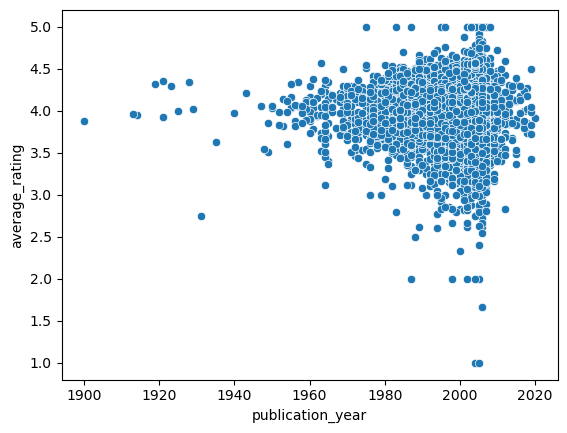

In [395]:
# Plot to show importance of publication year on average rating
sns.scatterplot(x='publication_year', y='average_rating', data=df_GoodReads)

<Axes: xlabel='pub_century', ylabel='average_rating'>

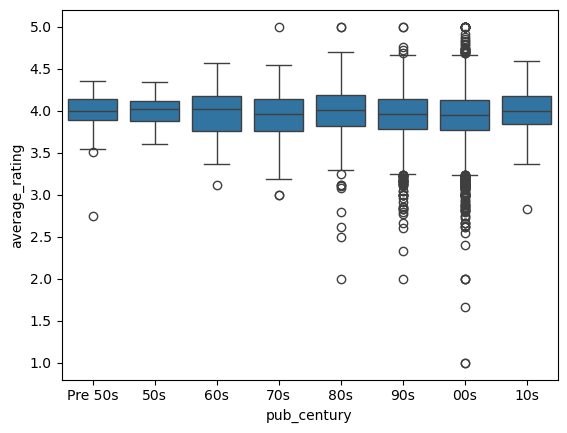

In [39]:
bins = [1900, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
labels = ['Pre 50s', '50s', '60s', '70s', '80s', '90s', '00s', '10s']
df_GoodReads['pub_century'] = pd.cut(df_GoodReads['publication_year'], bins=bins, labels=labels)
sns.boxplot(x='pub_century', y='average_rating', data= df_GoodReads)

<Axes: xlabel='publication_month', ylabel='average_rating'>

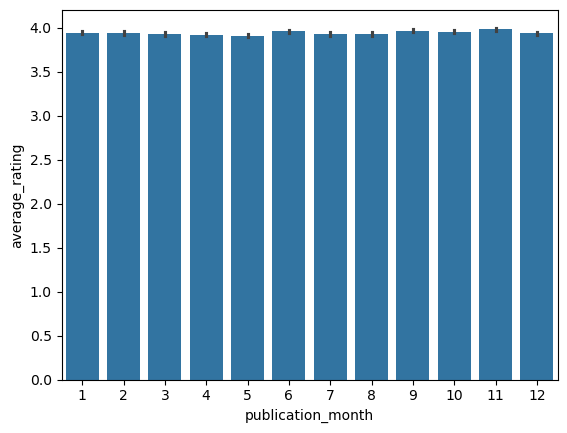

In [396]:
# Plot to show importance of publication month on average rating
sns.barplot(x='publication_month', y='average_rating', data=df_GoodReads)

<Axes: xlabel='publication_month', ylabel='average_rating'>

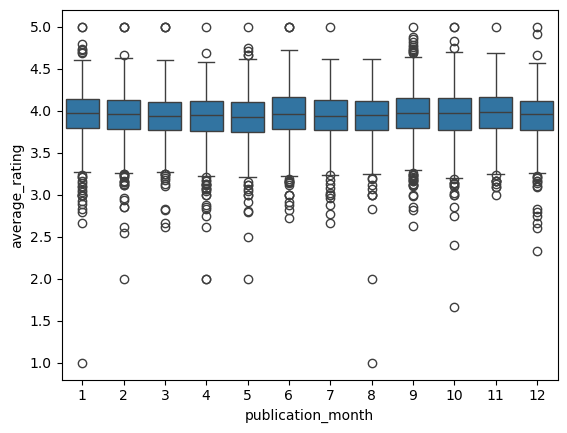

In [37]:
sns.boxplot(x='publication_month', y='average_rating', data= df_GoodReads)

In [397]:
# Little to no variation in rating across the months
df_GoodReads = df_GoodReads.drop('publication_month', axis=1)

<Axes: xlabel='average_rating', ylabel='num_pages'>

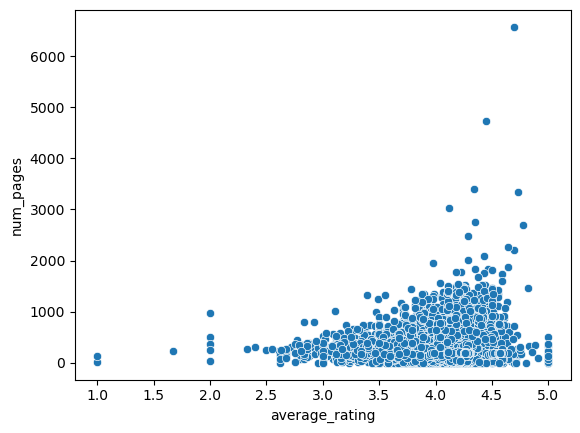

In [398]:
# Exploring the relationship between number of pages and average rating
sns.scatterplot(x='average_rating', y='num_pages', data=df_GoodReads)

In [399]:
# Eliminating outliers in num_pages category
# Over 2000 pages likely to be boxsets
# Under 10 pages likely to be audiobooks
df_GoodReads = df_GoodReads[df_GoodReads['num_pages']<= 2000]
df_GoodReads = df_GoodReads[df_GoodReads['num_pages'] >= 10]

<Axes: xlabel='average_rating', ylabel='num_pages'>

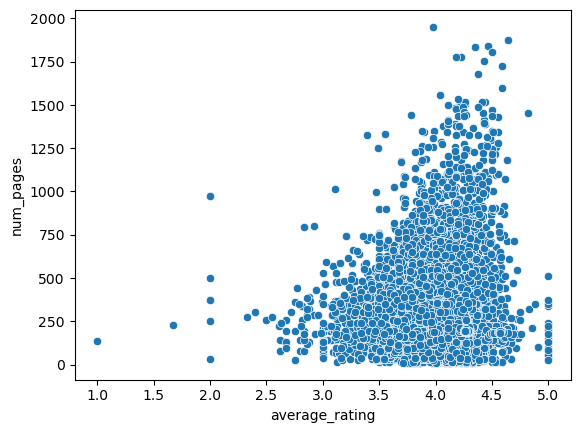

In [400]:
sns.scatterplot(x='average_rating', y='num_pages', data=df_GoodReads)

<Axes: xlabel='average_rating', ylabel='ratings_count'>

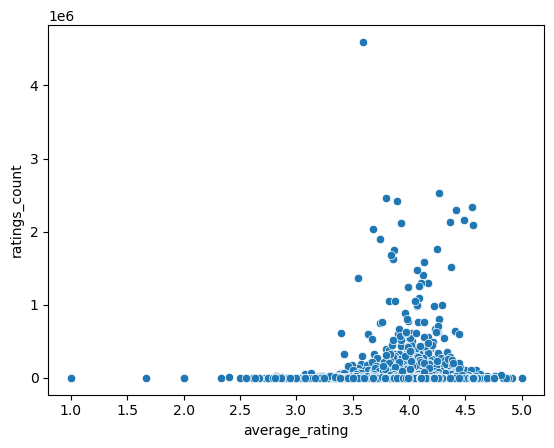

In [401]:
# Exploring the relationship between ratings count and average rating
sns.scatterplot(x='average_rating', y='ratings_count', data=df_GoodReads)

In [402]:
# We can see we have some very low ratings counts wrt to average which could be subject to human bias
# We will eliminate these potential outliers by eliminating the bottom 1%
lower_percentile = df_GoodReads['ratings_count'].quantile(0.01)
df_GoodReads = df_GoodReads[df_GoodReads['ratings_count'] > lower_percentile]

<Axes: xlabel='average_rating', ylabel='ratings_count'>

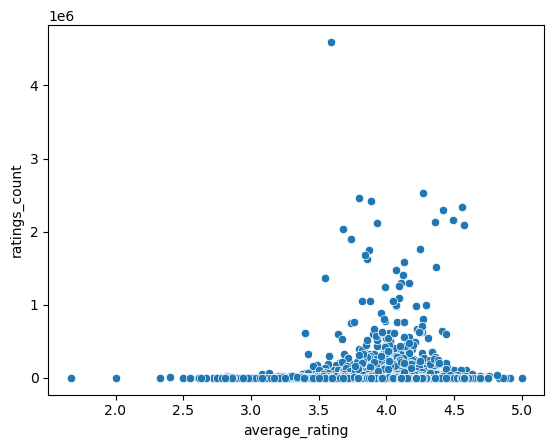

In [403]:
sns.scatterplot(x='average_rating', y='ratings_count', data=df_GoodReads)

<Axes: xlabel='average_rating', ylabel='text_reviews_count'>

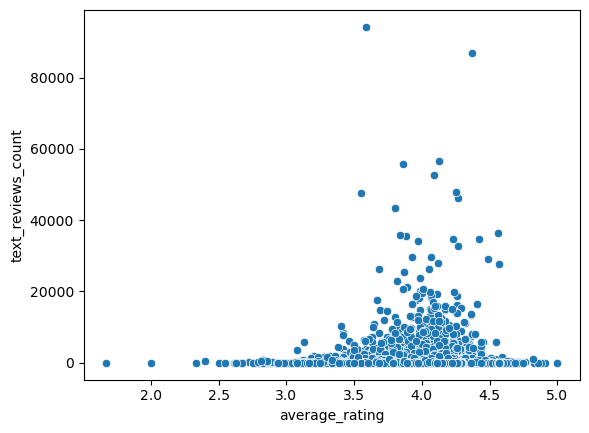

In [404]:
# Exploring the relationship between text reviews count and average rating
sns.scatterplot(x='average_rating', y='text_reviews_count', data=df_GoodReads)

<Axes: xlabel='text_review_conversion', ylabel='average_rating'>

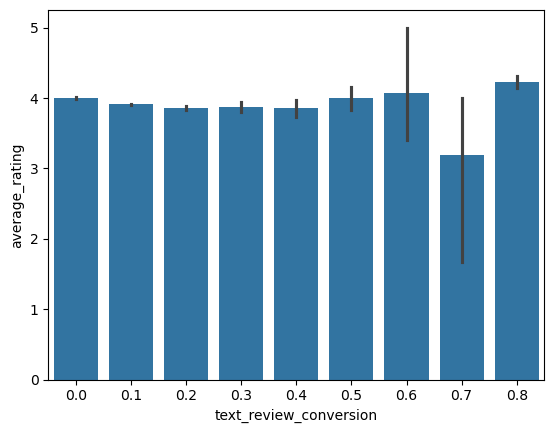

In [405]:
# Seeing if text review conversion is correlated to average rating (percentage text reviews left wrt ratings left)
df_GoodReads['text_review_conversion'] = np.where((df_GoodReads['text_reviews_count'] == 0) | (df_GoodReads['ratings_count'] == 0), 0, df_GoodReads['text_reviews_count'] / df_GoodReads['ratings_count']).round(1)
sns.barplot(x='text_review_conversion', y='average_rating', data=df_GoodReads)

In [406]:
df_GoodReads.head()

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publisher,titles_grouped,title_frequency,main_author,author_frequency,main_author_frequency,publisher_frequency,publication_year,text_review_conversion
bookID,,,,,,,,,,,,,,,
6549,said the shotgun to the head.,Saul Williams,4.22,192,2762,214,MTV Books,Unique,1,Saul Williams,1,1,2,2003,0.1
14490,$30 Film School: How to Write Direct Produce...,Michael W. Dean,3.49,528,30,4,Course Technology,How Write,4,Michael W. Dean,1,1,3,2003,0.1
5415,'Salem's Lot,Stephen King,4.02,405,1039,130,Doubleday,Salem Lot,5,Stephen King,66,83,6,1975,0.1
5413,'Salem's Lot,Stephen King,4.25,594,84123,571,Doubleday Books,Salem Lot,5,Stephen King,66,83,13,2005,0.0
5414,'Salem's Lot,Stephen King,4.02,17,227,54,Simon & Schuster Audio,Salem Lot,5,Stephen King,66,83,8,2004,0.2


In [407]:
# Convert categorical data to numeric
df_numeric = df_GoodReads
label_encoder = LabelEncoder()
df_numeric['title'] = label_encoder.fit_transform(df_numeric['title'])
df_numeric['main_author'] = label_encoder.fit_transform(df_numeric['main_author'])
df_numeric['titles_grouped'] = label_encoder.fit_transform(df_numeric['titles_grouped'])
df_numeric['authors'] = label_encoder.fit_transform(df_numeric['authors'])
df_numeric['publisher'] = label_encoder.fit_transform(df_numeric['publisher'])

In [408]:
df_numeric.head()

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publisher,titles_grouped,title_frequency,main_author,author_frequency,main_author_frequency,publisher_frequency,publication_year,text_review_conversion
bookID,,,,,,,,,,,,,,,
6549,0,3513,4.22,192,2762,214,1065,1159,1,3263,1,1,2,2003,0.1
14490,1,2723,3.49,528,30,4,401,528,4,2519,1,1,3,2003,0.1
5415,2,3645,4.02,405,1039,130,507,967,5,3382,66,83,6,1975,0.1
5413,2,3645,4.25,594,84123,571,508,967,5,3382,66,83,13,2005,0.0
5414,2,3645,4.02,17,227,54,1639,967,5,3382,66,83,8,2004,0.2


In [409]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10399 entries, 6549 to 15294
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   10399 non-null  int32  
 1   authors                 10399 non-null  int32  
 2   average_rating          10399 non-null  float64
 3   num_pages               10399 non-null  int64  
 4   ratings_count           10399 non-null  int64  
 5   text_reviews_count      10399 non-null  int64  
 6   publisher               10399 non-null  int32  
 7   titles_grouped          10399 non-null  int32  
 8   title_frequency         10399 non-null  int64  
 9   main_author             10399 non-null  int32  
 10  author_frequency        10399 non-null  int64  
 11  main_author_frequency   10399 non-null  int64  
 12  publisher_frequency     10399 non-null  int64  
 13  publication_year        10399 non-null  int32  
 14  text_review_conversion  10399 non-null  

In [410]:
print(df_numeric.corr())

                           title   authors  average_rating  num_pages  \
title                   1.000000  0.022841        0.020969   0.021275   
authors                 0.022841  1.000000        0.016668   0.002262   
average_rating          0.020969  0.016668        1.000000   0.177027   
num_pages               0.021275  0.002262        0.177027   1.000000   
ratings_count           0.003435  0.000432        0.042768   0.035846   
text_reviews_count      0.009942 -0.008410        0.035451   0.038683   
publisher               0.034677  0.017987        0.038725   0.011233   
titles_grouped          0.166826  0.031395       -0.108048  -0.040130   
title_frequency         0.019398 -0.004992        0.108610   0.016731   
main_author             0.019198  0.932736        0.018444   0.001581   
author_frequency       -0.000837  0.103681        0.071615   0.075034   
main_author_frequency  -0.006599  0.112593        0.061138   0.068482   
publisher_frequency     0.016155  0.008312       -0

In [411]:
# Dropping extra colums with repeat data
df_numeric = df_numeric.drop('title', axis=1)
df_numeric = df_numeric.drop('main_author', axis=1)
df_numeric = df_numeric.drop('authors', axis=1)
df_numeric = df_numeric.drop('main_author_frequency', axis=1)
df_numeric = df_numeric.drop('text_reviews_count', axis=1)
df_numeric = df_numeric.drop('publisher_frequency', axis=1)

In [412]:
print(df_numeric.corr())

                        average_rating  num_pages  ratings_count  publisher  \
average_rating                1.000000   0.177027       0.042768   0.038725   
num_pages                     0.177027   1.000000       0.035846   0.011233   
ratings_count                 0.042768   0.035846       1.000000   0.001824   
publisher                     0.038725   0.011233       0.001824   1.000000   
titles_grouped               -0.108048  -0.040130      -0.036497  -0.001966   
title_frequency               0.108610   0.016731       0.014172  -0.019583   
author_frequency              0.071615   0.075034       0.073263   0.026268   
publication_year             -0.046042  -0.010431       0.045777  -0.010814   
text_review_conversion       -0.161661  -0.088694      -0.127112  -0.023354   

                        titles_grouped  title_frequency  author_frequency  \
average_rating               -0.108048         0.108610          0.071615   
num_pages                    -0.040130         0.016731

In [413]:
px.imshow(df_numeric.corr())

In [414]:
# CLASSIFICATION MODEL using SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

In [432]:
# Putting average rating into categories

bins = [0, 3, 3.5, 4.5, 5]
labels = ['Poor', 'Below Average', 'Good', 'Excellent']
df_numeric['rating_category'] = pd.cut(df_numeric['average_rating'], bins=bins, labels=labels)
df_numeric.head()

,average_rating,num_pages,ratings_count,publisher,titles_grouped,title_frequency,author_frequency,publication_year,text_review_conversion,rating_category
bookID,,,,,,,,,,
6549,4.22,192,2762,1065,1159,1,1,2003,0.1,Good
14490,3.49,528,30,401,528,4,1,2003,0.1,Below Average
5415,4.02,405,1039,507,967,5,66,1975,0.1,Good
5413,4.25,594,84123,508,967,5,66,2005,0.0,Good
5414,4.02,17,227,1639,967,5,66,2004,0.2,Good


In [433]:
# Defining data

X = df_numeric[['num_pages', 'author_frequency', 'ratings_count', 'text_review_conversion', 'publication_year', 'titles_grouped']]
y = df_numeric['rating_category']

In [438]:
# Applying SMOTE

counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({'Good': 9557, 'Below Average': 636, 'Excellent': 154, 'Poor': 52})
Counter({'Good': 9557, 'Below Average': 9557, 'Excellent': 9557, 'Poor': 9557})


In [439]:
# Splitting data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [440]:
# Random Forest Classification

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200)

In [441]:
y_pred_rf = rf.predict(X_test)

In [442]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf}')

conf_matrix = confusion_matrix(y_test, y_pred_rf)
print(f'Confusion Matrix: \n{conf_matrix}')

class_report = classification_report(y_test, y_pred_rf)
print(f'Classification Report: \n{class_report}')

Accuracy: 0.9503008108815066
Confusion Matrix: 
[[1804    7  120   16]
 [   8 1888   12    9]
 [ 132   47 1680   26]
 [   3    0    0 1894]]
Classification Report: 
               precision    recall  f1-score   support

Below Average       0.93      0.93      0.93      1947
    Excellent       0.97      0.98      0.98      1917
         Good       0.93      0.89      0.91      1885
         Poor       0.97      1.00      0.99      1897

     accuracy                           0.95      7646
    macro avg       0.95      0.95      0.95      7646
 weighted avg       0.95      0.95      0.95      7646



In [422]:
# Cross validation for Random Forest Model
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print("Cross validation scores:", cv_score)
print("Cross validation average score:", cv_score.mean())

Cross validation scores: [0.9525242  0.95383207 0.95069317 0.9440157  0.94780903]
Cross validation average score: 0.9497748319309978


In [423]:
# KNN Classification
from sklearn.neighbors import KNeighborsClassifier

In [424]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [425]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy: {accuracy_knn}')

conf_matrix = confusion_matrix(y_test, y_pred_knn)
print(f'Confusion Matrix: \n{conf_matrix}')

class_report = classification_report(y_test, y_pred_knn)
print(f'Classification Report: \n{class_report}')

Accuracy: 0.8312843316766937
Confusion Matrix: 
[[1672   29  141   53]
 [  36 1766   66   21]
 [ 431  207 1108  190]
 [  54   13   49 1810]]
Classification Report: 
               precision    recall  f1-score   support

Below Average       0.76      0.88      0.82      1895
    Excellent       0.88      0.93      0.90      1889
         Good       0.81      0.57      0.67      1936
         Poor       0.87      0.94      0.91      1926

     accuracy                           0.83      7646
    macro avg       0.83      0.83      0.82      7646
 weighted avg       0.83      0.83      0.82      7646



In [426]:
# Cross validation for KNN
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
print("Cross validation scores:", cv_score)
print("Cross validation average score:", cv_score.mean())

Cross validation scores: [0.83337693 0.83429244 0.83769291 0.8351864  0.82746893]
Cross validation average score: 0.833603522242487


In [427]:
# Gradient Boosting Classification

from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [428]:
gbc = GradientBoostingClassifier(n_estimators=300, learning_rate=0.2, max_depth=8)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

In [429]:
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
print(f'Accuracy: {accuracy_gbc}')

conf_matrix = confusion_matrix(y_test, y_pred_gbc)
print(f'Confusion Matrix: \n{conf_matrix}')

class_report = classification_report(y_test, y_pred_gbc)
print(f'Classification Report: \n{class_report}')

Accuracy: 0.9503008108815066
Confusion Matrix: 
[[1785   10  131    9]
 [  11 1840   20    4]
 [ 122   48 1687   15]
 [   7    0    3 1954]]
Classification Report: 
               precision    recall  f1-score   support

Below Average       0.93      0.92      0.92      1935
    Excellent       0.97      0.98      0.98      1875
         Good       0.92      0.90      0.91      1872
         Poor       0.99      0.99      0.99      1964

     accuracy                           0.95      7646
    macro avg       0.95      0.95      0.95      7646
 weighted avg       0.95      0.95      0.95      7646



In [430]:
# Grid Search cross validation for Gradient Boosting
from sklearn.model_selection import GridSearchCV

gbcv = GradientBoostingClassifier()
parameters = {
    'n_estimators': [200, 300],
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 6]
}
grid = GridSearchCV(estimator=gbcv, param_grid=parameters, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)
print("Best Hyperparameters:", grid.best_params_)
print("Best Cross Validation Accuracy:", grid.best_score_)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300}
Best Cross Validation Accuracy: 0.9401281799751487


In [431]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9510855349202197
